# Example analysis pipeline

## Simple comparison of neural activity during stimulus condition on/off 


Load in relevant local application modules:

In [1]:
import sys
import matplotlib.pyplot as plt

from types import SimpleNamespace
import inflect

# Local application imports 
from database.db_setup import *
import preprocessing.data_preprocessing.binning as binning
import preprocessing.data_preprocessing.create_vectors_from_time_points as create
import annotation.stimulus_driven_annotation.movies.annotation_utils as utils

Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306


Set parameters:

In [39]:
patient_id = 2
session_nr = 1
unit_nr = 0
bin_size = 1000

Get activity from the database, set binning parameters, and bin: 

In [61]:
spike_times = get_spiking_activity(patient_id, session_nr, unit_nr)
#spike_times = spike_times / 1000

exclude_pauses = False
output_edges = True

binned_spikes, edges = binning.bin_spikes(patient_id, session_nr, spike_times, bin_size, exclude_pauses, output_edges)

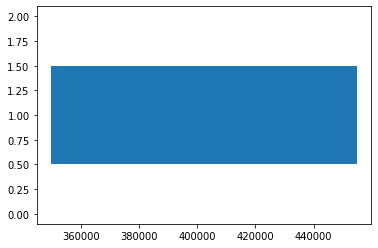

In [51]:
plt.eventplot(spike_times)

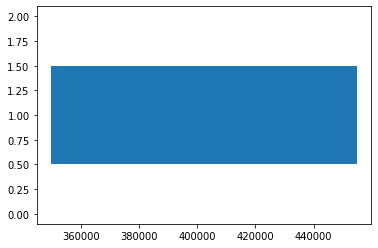

In [50]:
plt.eventplot(np.sort(spike_times))

In [57]:
(np.max(spike_times) - np.min(spike_times)) / 1000 / 60 

1.746364375564099

In [47]:
spike_times = np.sort(spike_times)

In [62]:
rectime = get_neural_rectime_of_patient(patient_id, session_nr) / 1000
rec_on = np.min(spike_times)
rec_off = np.max(spike_times)

total_msec = rec_off - rec_on
total_bins = int(total_msec / bin_size)
bins = np.linspace(rec_on, rec_off, total_bins)


# bin spikes
binned_spikes, _ = np.histogram(spike_times, bins=bins)

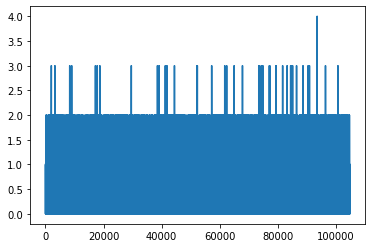

In [63]:
plt.plot(binned_spikes)

29.105555555555554

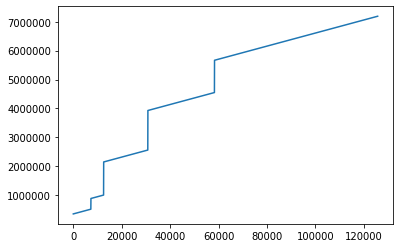

In [43]:
plt.plot(rectime)

In [58]:
(rec_off - rec_on) / 1000 / 60

114.01640938333334

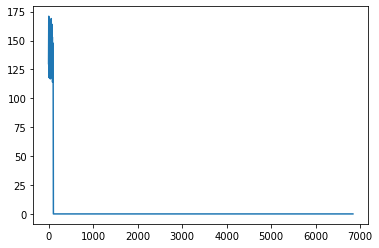

In [49]:
plt.plot(binned_spikes)

Using edges outputted above, generate a vector representing when a feature was presented during the stimulus:  

In [6]:
PatientAlignedMovieAnnotation()

annotator_id unique ID for each annotator,label_name label name,annotation_date date of annotation,session_nr session ID,patient_id patient ID,label_in_patient_time label matched to patient time (pts),values list of values that represent label,start_times list of start times of label segments in neural recording time,stop_times list of stop times of label segments in neural recording time,additionl_information
p2,character1,2019-12-12,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character1,2019-12-12,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character1,2019-12-12,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,location1,2020-01-01,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,location1,2020-01-01,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,location1,2020-01-01,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,


In [7]:
label_name = "character1"
annotator_id = "p2"
annotation_date = "2019-12-12	"

values, starts, stops = get_patient_aligned_annotations(patient_id, label_name, annotator_id, annotation_date)

In [8]:
character1_binned = create.create_vector_from_start_stop_times_reference(edges, values, starts, stops)

In [26]:
spike_times[0]

456953.68551497743

In [19]:
edges[-1] - edges[0]

5314016.07475

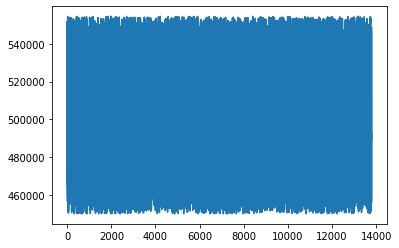

In [28]:
plt.plot(spike_times)

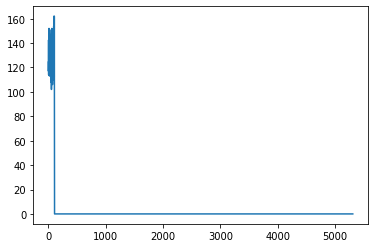

In [29]:
plt.plot(binned_spikes)

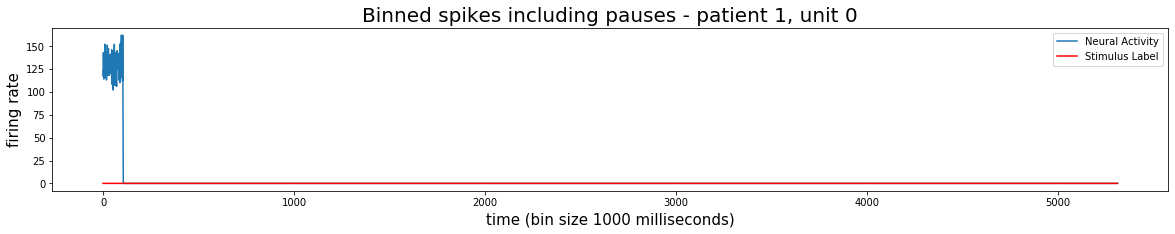

In [27]:
fig = plt.figure(figsize=(20,3))
plt.plot(binned_spikes, label="Neural Activity")
plt.plot(character1_binned, color="r", label="Stimulus Label")
if exclude_pauses:
    plt.title("Binned spikes excluding pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
else:
    plt.title("Binned spikes including pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
plt.xlabel("time (bin size {} milliseconds)".format(bin_size), fontsize=15)
plt.ylabel("firing rate", fontsize=15)

plt.legend()

plt.show()

Split activity into groups corresponding to the stimulus values, 

* One: Stimulus-on condition 
* Zero: Stimulus-off condition

In [65]:
tom_splits = utils.split_activity_by_value(binned_spikes, tom_binned)
tom_activity = SimpleNamespace(**tom_splits)

In [66]:
print(tom_activity.zero)
print(tom_activity.one)

print(len(tom_activity.zero) + len(tom_activity.one))
print(len(tom_binned))

[0 1 1 ... 0 0 0]
[4 1 2 ... 0 1 0]
4804
4804


In [69]:
## TODO, add in perm testing module to use here 
## TODO: mock movie labels (original labels,  and then mock patient aligned labels. check that the watchlog can be sufficiently busted up )

